# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

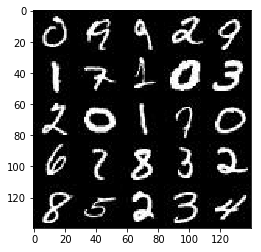

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

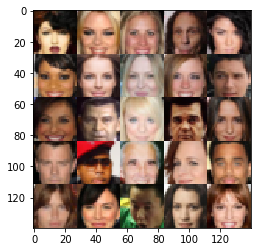

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [79]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        #should start with size same as image: 28x28x3
        #1st conv layer
        x1 = tf.layers.conv2d(images, 16, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x16
        #2nd conv layer
        x2 = tf.layers.conv2d(relu1, 32, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x32
        #3rd conv layer, use strides 1 to keep heightxwidth same as previous layer at 7x7
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x64

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        #output layer
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer with z input
        #should carry the same size as discriminator's output 
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional layer
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x64 now
        # 2nd conv layer
        x2 = tf.layers.conv2d_transpose(x1, 32, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x32 now
        # 3rd conv layer
        x3 = tf.layers.conv2d_transpose(x2, 16, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x16 now
        # 4th conv layer
        # use strides 1 to keep this layer at same heightxwidth at 28x28
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        #Output layer        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [76]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #calcalute loss using reduce_mean on sigmoid_cross_entropy_with_logits between logits and labels
    # discriminator real wants labels of 1's
    # discriminator fake wants labels of 0's
    # generator's  fake wants labels of 1's to fool discriminator
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [73]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
       
    #print('data_shape={}',format(data_shape))
    #print('z_dim={}',format(z_dim))
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(image_width=data_shape[1],
                                       image_height=data_shape[2],
                                       image_channels=data_shape[3],
                                       z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    
    #saver = tf.train.Saver()
    num_sample_image = 20
    #sample_z = np.random.uniform(-1, 1, size=(num_sample_image, z_dim))
    sample_z = tf.random_uniform((num_sample_image, z_dim))

    #print("sample_z.get_shape={}",format(sample_z.get_shape()))
    
    steps = 0
    print_every = 10
    show_every = 100
    
    #start a session to train model with feed_dict to inputs
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = tf.random_uniform((batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} steps {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images=num_sample_image, input_z=sample_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
    
        print("end of loop")
        #saver.save(sess, 'generator.ckpt')

    print("about to exit train()")
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 steps 10... Discriminator Loss: 0.9942... Generator Loss: 1.4172
Epoch 1/2 steps 20... Discriminator Loss: 3.1698... Generator Loss: 0.4177
Epoch 1/2 steps 30... Discriminator Loss: 3.5750... Generator Loss: 4.0034
Epoch 1/2 steps 40... Discriminator Loss: 3.5567... Generator Loss: 0.1541
Epoch 1/2 steps 50... Discriminator Loss: 1.8631... Generator Loss: 3.4155
Epoch 1/2 steps 60... Discriminator Loss: 0.4570... Generator Loss: 2.1946
Epoch 1/2 steps 70... Discriminator Loss: 0.8044... Generator Loss: 4.1437
Epoch 1/2 steps 80... Discriminator Loss: 2.6196... Generator Loss: 0.1149
Epoch 1/2 steps 90... Discriminator Loss: 4.2189... Generator Loss: 0.0754
Epoch 1/2 steps 100... Discriminator Loss: 0.8583... Generator Loss: 0.9027


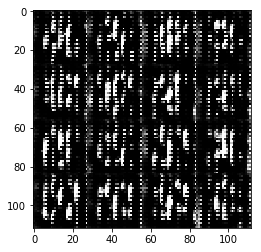

Epoch 1/2 steps 110... Discriminator Loss: 0.2371... Generator Loss: 2.4496
Epoch 1/2 steps 120... Discriminator Loss: 0.7868... Generator Loss: 9.7744
Epoch 1/2 steps 130... Discriminator Loss: 11.3839... Generator Loss: 15.3960
Epoch 1/2 steps 140... Discriminator Loss: 0.0781... Generator Loss: 3.9189
Epoch 1/2 steps 150... Discriminator Loss: 1.9329... Generator Loss: 0.2624
Epoch 1/2 steps 160... Discriminator Loss: 0.7714... Generator Loss: 0.9145
Epoch 1/2 steps 170... Discriminator Loss: 0.3054... Generator Loss: 2.4973
Epoch 1/2 steps 180... Discriminator Loss: 1.0760... Generator Loss: 0.7076
Epoch 1/2 steps 190... Discriminator Loss: 0.2017... Generator Loss: 3.3881
Epoch 1/2 steps 200... Discriminator Loss: 4.7514... Generator Loss: 9.6453


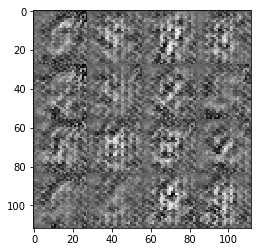

Epoch 1/2 steps 210... Discriminator Loss: 2.1071... Generator Loss: 2.1930
Epoch 1/2 steps 220... Discriminator Loss: 0.1229... Generator Loss: 2.7431
Epoch 1/2 steps 230... Discriminator Loss: 2.2125... Generator Loss: 2.4707
Epoch 1/2 steps 240... Discriminator Loss: 2.6891... Generator Loss: 0.2125
Epoch 1/2 steps 250... Discriminator Loss: 0.6990... Generator Loss: 1.2464
Epoch 1/2 steps 260... Discriminator Loss: 1.3980... Generator Loss: 0.5826
Epoch 1/2 steps 270... Discriminator Loss: 1.8111... Generator Loss: 1.5190
Epoch 1/2 steps 280... Discriminator Loss: 0.4623... Generator Loss: 1.6715
Epoch 1/2 steps 290... Discriminator Loss: 1.0848... Generator Loss: 1.7245
Epoch 1/2 steps 300... Discriminator Loss: 2.0972... Generator Loss: 0.3213


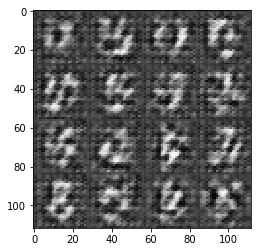

Epoch 1/2 steps 310... Discriminator Loss: 2.5593... Generator Loss: 0.1308
Epoch 1/2 steps 320... Discriminator Loss: 1.0116... Generator Loss: 0.7466
Epoch 1/2 steps 330... Discriminator Loss: 0.8275... Generator Loss: 1.2670
Epoch 1/2 steps 340... Discriminator Loss: 1.5523... Generator Loss: 2.4983
Epoch 1/2 steps 350... Discriminator Loss: 0.8300... Generator Loss: 0.9728
Epoch 1/2 steps 360... Discriminator Loss: 1.0994... Generator Loss: 0.5629
Epoch 1/2 steps 370... Discriminator Loss: 2.3505... Generator Loss: 0.3368
Epoch 1/2 steps 380... Discriminator Loss: 1.3294... Generator Loss: 2.9550
Epoch 1/2 steps 390... Discriminator Loss: 0.8722... Generator Loss: 1.0764
Epoch 1/2 steps 400... Discriminator Loss: 3.8408... Generator Loss: 4.1657


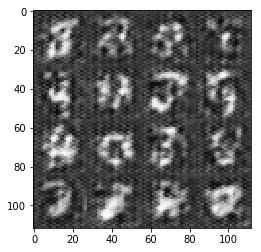

Epoch 1/2 steps 410... Discriminator Loss: 1.0644... Generator Loss: 1.1831
Epoch 1/2 steps 420... Discriminator Loss: 0.7032... Generator Loss: 1.3832
Epoch 1/2 steps 430... Discriminator Loss: 1.7123... Generator Loss: 0.5936
Epoch 1/2 steps 440... Discriminator Loss: 1.8726... Generator Loss: 0.2996
Epoch 1/2 steps 450... Discriminator Loss: 0.6203... Generator Loss: 1.6010
Epoch 1/2 steps 460... Discriminator Loss: 0.7955... Generator Loss: 1.9577
Epoch 1/2 steps 470... Discriminator Loss: 2.7823... Generator Loss: 0.1710
Epoch 1/2 steps 480... Discriminator Loss: 0.6514... Generator Loss: 1.1639
Epoch 1/2 steps 490... Discriminator Loss: 2.7271... Generator Loss: 3.6435
Epoch 1/2 steps 500... Discriminator Loss: 0.7126... Generator Loss: 1.1688


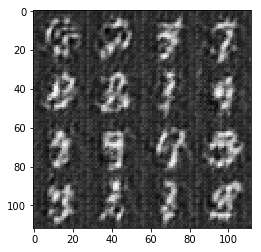

Epoch 1/2 steps 510... Discriminator Loss: 0.7971... Generator Loss: 1.0024
Epoch 1/2 steps 520... Discriminator Loss: 0.2625... Generator Loss: 1.8897
Epoch 1/2 steps 530... Discriminator Loss: 0.2851... Generator Loss: 3.1589
Epoch 1/2 steps 540... Discriminator Loss: 0.3311... Generator Loss: 2.4172
Epoch 1/2 steps 550... Discriminator Loss: 1.7929... Generator Loss: 0.3468
Epoch 1/2 steps 560... Discriminator Loss: 0.6724... Generator Loss: 1.4662
Epoch 1/2 steps 570... Discriminator Loss: 1.9127... Generator Loss: 4.4104
Epoch 1/2 steps 580... Discriminator Loss: 1.2075... Generator Loss: 0.6787
Epoch 1/2 steps 590... Discriminator Loss: 0.4681... Generator Loss: 1.3378
Epoch 1/2 steps 600... Discriminator Loss: 1.3924... Generator Loss: 0.3797


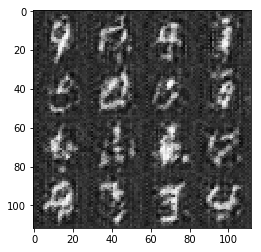

Epoch 1/2 steps 610... Discriminator Loss: 0.6765... Generator Loss: 1.4734
Epoch 1/2 steps 620... Discriminator Loss: 0.6912... Generator Loss: 1.1360
Epoch 1/2 steps 630... Discriminator Loss: 0.4141... Generator Loss: 1.6965
Epoch 1/2 steps 640... Discriminator Loss: 0.1268... Generator Loss: 3.3322
Epoch 1/2 steps 650... Discriminator Loss: 0.1314... Generator Loss: 2.7729
Epoch 1/2 steps 660... Discriminator Loss: 0.1146... Generator Loss: 4.2788
Epoch 1/2 steps 670... Discriminator Loss: 0.7691... Generator Loss: 1.0155
Epoch 1/2 steps 680... Discriminator Loss: 4.0972... Generator Loss: 4.4206
Epoch 1/2 steps 690... Discriminator Loss: 1.2210... Generator Loss: 2.2153
Epoch 1/2 steps 700... Discriminator Loss: 1.0757... Generator Loss: 2.4249


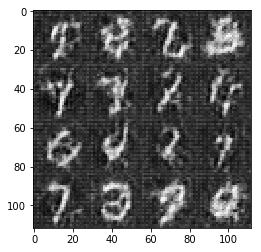

Epoch 1/2 steps 710... Discriminator Loss: 1.0944... Generator Loss: 0.6684
Epoch 1/2 steps 720... Discriminator Loss: 0.8191... Generator Loss: 1.0236
Epoch 1/2 steps 730... Discriminator Loss: 0.9313... Generator Loss: 0.7488
Epoch 1/2 steps 740... Discriminator Loss: 1.5203... Generator Loss: 0.3830
Epoch 1/2 steps 750... Discriminator Loss: 0.4363... Generator Loss: 1.7154
Epoch 1/2 steps 760... Discriminator Loss: 1.5721... Generator Loss: 0.3807
Epoch 1/2 steps 770... Discriminator Loss: 1.7980... Generator Loss: 0.3015
Epoch 1/2 steps 780... Discriminator Loss: 1.4912... Generator Loss: 0.3327
Epoch 1/2 steps 790... Discriminator Loss: 1.4668... Generator Loss: 2.1654
Epoch 1/2 steps 800... Discriminator Loss: 1.0533... Generator Loss: 0.6849


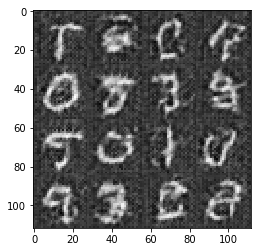

Epoch 1/2 steps 810... Discriminator Loss: 0.4653... Generator Loss: 1.6377
Epoch 1/2 steps 820... Discriminator Loss: 0.9914... Generator Loss: 4.1033
Epoch 1/2 steps 830... Discriminator Loss: 1.2269... Generator Loss: 3.6585
Epoch 1/2 steps 840... Discriminator Loss: 0.9391... Generator Loss: 0.7877
Epoch 1/2 steps 850... Discriminator Loss: 0.5586... Generator Loss: 1.4822
Epoch 1/2 steps 860... Discriminator Loss: 0.5573... Generator Loss: 1.1014
Epoch 1/2 steps 870... Discriminator Loss: 0.3291... Generator Loss: 1.7256
Epoch 1/2 steps 880... Discriminator Loss: 0.0360... Generator Loss: 4.4888
Epoch 1/2 steps 890... Discriminator Loss: 0.4070... Generator Loss: 1.4506
Epoch 1/2 steps 900... Discriminator Loss: 0.0375... Generator Loss: 5.8195


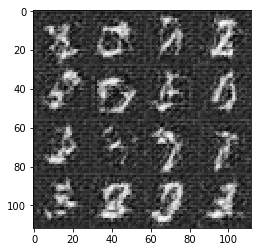

Epoch 1/2 steps 910... Discriminator Loss: 0.4997... Generator Loss: 1.2052
Epoch 1/2 steps 920... Discriminator Loss: 0.0273... Generator Loss: 5.0908
Epoch 1/2 steps 930... Discriminator Loss: 0.0140... Generator Loss: 5.5047
Epoch 2/2 steps 940... Discriminator Loss: 2.8665... Generator Loss: 5.1956
Epoch 2/2 steps 950... Discriminator Loss: 1.4609... Generator Loss: 0.4498
Epoch 2/2 steps 960... Discriminator Loss: 0.8379... Generator Loss: 0.8626
Epoch 2/2 steps 970... Discriminator Loss: 0.7004... Generator Loss: 0.9195
Epoch 2/2 steps 980... Discriminator Loss: 0.1067... Generator Loss: 3.0566
Epoch 2/2 steps 990... Discriminator Loss: 0.2289... Generator Loss: 2.9420
Epoch 2/2 steps 1000... Discriminator Loss: 1.2544... Generator Loss: 0.4943


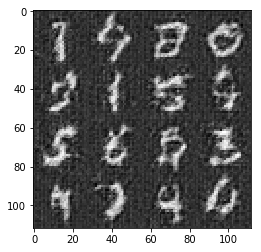

Epoch 2/2 steps 1010... Discriminator Loss: 0.9632... Generator Loss: 0.6530
Epoch 2/2 steps 1020... Discriminator Loss: 1.0512... Generator Loss: 1.0596
Epoch 2/2 steps 1030... Discriminator Loss: 0.8101... Generator Loss: 2.5400
Epoch 2/2 steps 1040... Discriminator Loss: 0.7510... Generator Loss: 2.0863
Epoch 2/2 steps 1050... Discriminator Loss: 0.5579... Generator Loss: 1.6784
Epoch 2/2 steps 1060... Discriminator Loss: 0.3670... Generator Loss: 3.4296
Epoch 2/2 steps 1070... Discriminator Loss: 0.6255... Generator Loss: 1.6443
Epoch 2/2 steps 1080... Discriminator Loss: 0.0968... Generator Loss: 3.5828
Epoch 2/2 steps 1090... Discriminator Loss: 0.5428... Generator Loss: 1.2285
Epoch 2/2 steps 1100... Discriminator Loss: 0.2174... Generator Loss: 3.8566


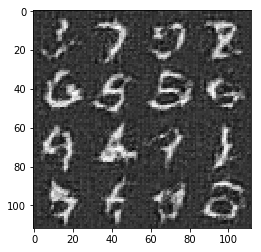

Epoch 2/2 steps 1110... Discriminator Loss: 0.3508... Generator Loss: 1.6545
Epoch 2/2 steps 1120... Discriminator Loss: 0.3575... Generator Loss: 1.6341
Epoch 2/2 steps 1130... Discriminator Loss: 0.4134... Generator Loss: 1.3927
Epoch 2/2 steps 1140... Discriminator Loss: 1.1862... Generator Loss: 1.7596
Epoch 2/2 steps 1150... Discriminator Loss: 0.9632... Generator Loss: 0.8580
Epoch 2/2 steps 1160... Discriminator Loss: 0.8338... Generator Loss: 0.8452
Epoch 2/2 steps 1170... Discriminator Loss: 0.6450... Generator Loss: 2.8804
Epoch 2/2 steps 1180... Discriminator Loss: 0.6044... Generator Loss: 1.4694
Epoch 2/2 steps 1190... Discriminator Loss: 0.9086... Generator Loss: 0.9006
Epoch 2/2 steps 1200... Discriminator Loss: 0.4015... Generator Loss: 1.8283


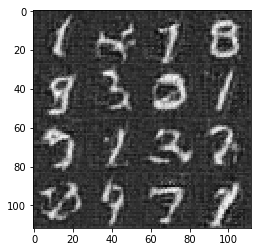

Epoch 2/2 steps 1210... Discriminator Loss: 0.6352... Generator Loss: 1.3514
Epoch 2/2 steps 1220... Discriminator Loss: 0.7680... Generator Loss: 1.0351
Epoch 2/2 steps 1230... Discriminator Loss: 0.7566... Generator Loss: 0.9706
Epoch 2/2 steps 1240... Discriminator Loss: 0.2613... Generator Loss: 3.7613
Epoch 2/2 steps 1250... Discriminator Loss: 0.7156... Generator Loss: 0.9717
Epoch 2/2 steps 1260... Discriminator Loss: 0.1115... Generator Loss: 2.9804
Epoch 2/2 steps 1270... Discriminator Loss: 0.0429... Generator Loss: 5.9393
Epoch 2/2 steps 1280... Discriminator Loss: 0.1228... Generator Loss: 2.8159
Epoch 2/2 steps 1290... Discriminator Loss: 0.3731... Generator Loss: 1.6260
Epoch 2/2 steps 1300... Discriminator Loss: 0.9031... Generator Loss: 1.0764


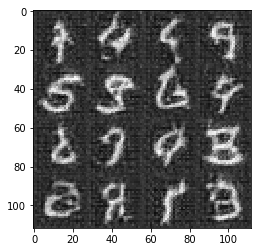

Epoch 2/2 steps 1310... Discriminator Loss: 0.4380... Generator Loss: 3.4510
Epoch 2/2 steps 1320... Discriminator Loss: 1.1553... Generator Loss: 0.7396
Epoch 2/2 steps 1330... Discriminator Loss: 0.7109... Generator Loss: 1.1451
Epoch 2/2 steps 1340... Discriminator Loss: 0.3505... Generator Loss: 2.2509
Epoch 2/2 steps 1350... Discriminator Loss: 0.0642... Generator Loss: 4.8044
Epoch 2/2 steps 1360... Discriminator Loss: 0.1228... Generator Loss: 5.1625
Epoch 2/2 steps 1370... Discriminator Loss: 0.3771... Generator Loss: 1.6475
Epoch 2/2 steps 1380... Discriminator Loss: 0.1697... Generator Loss: 2.7628
Epoch 2/2 steps 1390... Discriminator Loss: 0.1281... Generator Loss: 7.0736
Epoch 2/2 steps 1400... Discriminator Loss: 0.7931... Generator Loss: 1.3250


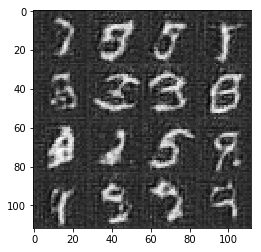

Epoch 2/2 steps 1410... Discriminator Loss: 2.3530... Generator Loss: 3.6427
Epoch 2/2 steps 1420... Discriminator Loss: 0.6593... Generator Loss: 2.5856
Epoch 2/2 steps 1430... Discriminator Loss: 2.1729... Generator Loss: 0.2647
Epoch 2/2 steps 1440... Discriminator Loss: 0.7844... Generator Loss: 1.0716
Epoch 2/2 steps 1450... Discriminator Loss: 0.6443... Generator Loss: 1.1916
Epoch 2/2 steps 1460... Discriminator Loss: 0.8509... Generator Loss: 0.9937
Epoch 2/2 steps 1470... Discriminator Loss: 1.0672... Generator Loss: 1.9364
Epoch 2/2 steps 1480... Discriminator Loss: 1.3307... Generator Loss: 3.8648
Epoch 2/2 steps 1490... Discriminator Loss: 0.4657... Generator Loss: 1.7888
Epoch 2/2 steps 1500... Discriminator Loss: 0.6806... Generator Loss: 1.1760


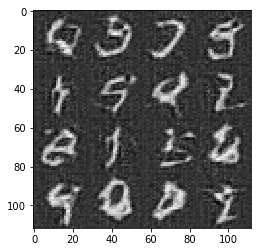

Epoch 2/2 steps 1510... Discriminator Loss: 1.3116... Generator Loss: 0.6229
Epoch 2/2 steps 1520... Discriminator Loss: 0.1460... Generator Loss: 2.8943
Epoch 2/2 steps 1530... Discriminator Loss: 0.1212... Generator Loss: 3.0512
Epoch 2/2 steps 1540... Discriminator Loss: 0.6187... Generator Loss: 1.2769
Epoch 2/2 steps 1550... Discriminator Loss: 1.2655... Generator Loss: 0.6318
Epoch 2/2 steps 1560... Discriminator Loss: 0.6863... Generator Loss: 2.8300
Epoch 2/2 steps 1570... Discriminator Loss: 0.6066... Generator Loss: 2.4424
Epoch 2/2 steps 1580... Discriminator Loss: 0.6072... Generator Loss: 1.2869
Epoch 2/2 steps 1590... Discriminator Loss: 0.5368... Generator Loss: 1.2992
Epoch 2/2 steps 1600... Discriminator Loss: 1.1206... Generator Loss: 0.6127


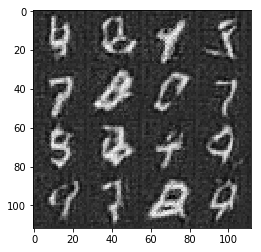

Epoch 2/2 steps 1610... Discriminator Loss: 0.2337... Generator Loss: 4.0359
Epoch 2/2 steps 1620... Discriminator Loss: 5.8712... Generator Loss: 4.7842
Epoch 2/2 steps 1630... Discriminator Loss: 0.8703... Generator Loss: 1.5165
Epoch 2/2 steps 1640... Discriminator Loss: 0.3987... Generator Loss: 2.2159
Epoch 2/2 steps 1650... Discriminator Loss: 0.4044... Generator Loss: 2.0165
Epoch 2/2 steps 1660... Discriminator Loss: 0.7601... Generator Loss: 0.9530
Epoch 2/2 steps 1670... Discriminator Loss: 0.0681... Generator Loss: 3.8111
Epoch 2/2 steps 1680... Discriminator Loss: 0.3063... Generator Loss: 1.8359
Epoch 2/2 steps 1690... Discriminator Loss: 0.0394... Generator Loss: 4.9602
Epoch 2/2 steps 1700... Discriminator Loss: 0.0384... Generator Loss: 4.3326


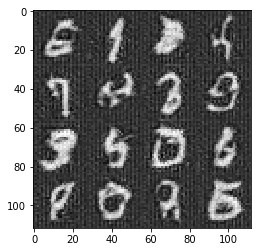

Epoch 2/2 steps 1710... Discriminator Loss: 0.2654... Generator Loss: 1.9361
Epoch 2/2 steps 1720... Discriminator Loss: 2.8346... Generator Loss: 0.1326
Epoch 2/2 steps 1730... Discriminator Loss: 0.6705... Generator Loss: 1.6724
Epoch 2/2 steps 1740... Discriminator Loss: 0.9911... Generator Loss: 3.4668
Epoch 2/2 steps 1750... Discriminator Loss: 0.1626... Generator Loss: 2.7801
Epoch 2/2 steps 1760... Discriminator Loss: 1.9844... Generator Loss: 0.3210
Epoch 2/2 steps 1770... Discriminator Loss: 0.6418... Generator Loss: 2.1254
Epoch 2/2 steps 1780... Discriminator Loss: 0.4462... Generator Loss: 1.7867
Epoch 2/2 steps 1790... Discriminator Loss: 0.8649... Generator Loss: 0.8356
Epoch 2/2 steps 1800... Discriminator Loss: 0.3248... Generator Loss: 2.1141


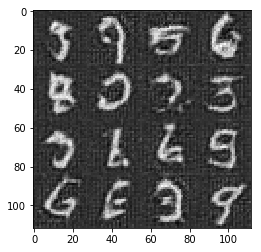

Epoch 2/2 steps 1810... Discriminator Loss: 0.5590... Generator Loss: 1.1780
Epoch 2/2 steps 1820... Discriminator Loss: 0.2883... Generator Loss: 2.0942
Epoch 2/2 steps 1830... Discriminator Loss: 0.3218... Generator Loss: 1.7065
Epoch 2/2 steps 1840... Discriminator Loss: 0.0494... Generator Loss: 4.3571
Epoch 2/2 steps 1850... Discriminator Loss: 0.3870... Generator Loss: 1.5621
Epoch 2/2 steps 1860... Discriminator Loss: 0.7830... Generator Loss: 0.9218
Epoch 2/2 steps 1870... Discriminator Loss: 0.5224... Generator Loss: 1.2634
end of loop
about to exit train()
done training mnist
done-tf.graph
done mnist_dataset (60000, 28, 28, 1)L


In [84]:
'''
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.3

result
Epoch 2/2 steps 1870... Discriminator Loss: 0.3786... Generator Loss: 1.5388
'''

batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    print("done training mnist")
print("done-tf.graph")

print("done mnist_dataset {}{}".format(mnist_dataset.shape, mnist_dataset.image_mode))


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 steps 10... Discriminator Loss: 1.4837... Generator Loss: 1.1488
Epoch 1/1 steps 20... Discriminator Loss: 1.5043... Generator Loss: 0.6382
Epoch 1/1 steps 30... Discriminator Loss: 1.2294... Generator Loss: 0.8660
Epoch 1/1 steps 40... Discriminator Loss: 1.1672... Generator Loss: 0.7162
Epoch 1/1 steps 50... Discriminator Loss: 0.1296... Generator Loss: 2.9249
Epoch 1/1 steps 60... Discriminator Loss: 0.0048... Generator Loss: 6.9847
Epoch 1/1 steps 70... Discriminator Loss: 0.1033... Generator Loss: 2.4980
Epoch 1/1 steps 80... Discriminator Loss: 0.1123... Generator Loss: 2.8594
Epoch 1/1 steps 90... Discriminator Loss: 0.1496... Generator Loss: 2.2211
Epoch 1/1 steps 100... Discriminator Loss: 0.0064... Generator Loss: 6.1864


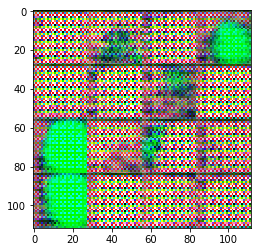

Epoch 1/1 steps 110... Discriminator Loss: 0.0098... Generator Loss: 5.5726
Epoch 1/1 steps 120... Discriminator Loss: 0.0132... Generator Loss: 4.7878
Epoch 1/1 steps 130... Discriminator Loss: 0.0456... Generator Loss: 3.5159
Epoch 1/1 steps 140... Discriminator Loss: 0.3849... Generator Loss: 1.5026
Epoch 1/1 steps 150... Discriminator Loss: 0.2312... Generator Loss: 1.9219
Epoch 1/1 steps 160... Discriminator Loss: 3.3653... Generator Loss: 0.3141
Epoch 1/1 steps 170... Discriminator Loss: 0.0090... Generator Loss: 12.0503
Epoch 1/1 steps 180... Discriminator Loss: 0.1037... Generator Loss: 10.4296
Epoch 1/1 steps 190... Discriminator Loss: 0.0029... Generator Loss: 11.1946
Epoch 1/1 steps 200... Discriminator Loss: 0.0037... Generator Loss: 6.4784


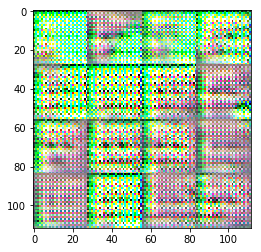

Epoch 1/1 steps 210... Discriminator Loss: 0.0077... Generator Loss: 5.6261
Epoch 1/1 steps 220... Discriminator Loss: 0.0015... Generator Loss: 8.0561
Epoch 1/1 steps 230... Discriminator Loss: 4.2142... Generator Loss: 0.1524
Epoch 1/1 steps 240... Discriminator Loss: 0.1395... Generator Loss: 3.6646
Epoch 1/1 steps 250... Discriminator Loss: 1.2078... Generator Loss: 0.7561
Epoch 1/1 steps 260... Discriminator Loss: 0.4723... Generator Loss: 2.0383
Epoch 1/1 steps 270... Discriminator Loss: 0.3548... Generator Loss: 1.7587
Epoch 1/1 steps 280... Discriminator Loss: 2.1561... Generator Loss: 4.3515
Epoch 1/1 steps 290... Discriminator Loss: 0.1733... Generator Loss: 2.9558
Epoch 1/1 steps 300... Discriminator Loss: 1.8776... Generator Loss: 0.3991


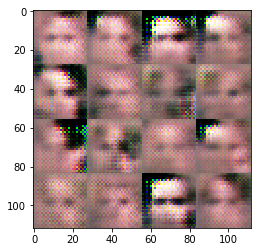

Epoch 1/1 steps 310... Discriminator Loss: 3.6798... Generator Loss: 5.7590
Epoch 1/1 steps 320... Discriminator Loss: 3.7838... Generator Loss: 5.5467
Epoch 1/1 steps 330... Discriminator Loss: 5.3217... Generator Loss: 6.1806
Epoch 1/1 steps 340... Discriminator Loss: 0.5806... Generator Loss: 1.3640
Epoch 1/1 steps 350... Discriminator Loss: 0.3728... Generator Loss: 2.1336
Epoch 1/1 steps 360... Discriminator Loss: 0.3842... Generator Loss: 1.8856
Epoch 1/1 steps 370... Discriminator Loss: 0.8224... Generator Loss: 2.2502
Epoch 1/1 steps 380... Discriminator Loss: 0.6308... Generator Loss: 4.2319
Epoch 1/1 steps 390... Discriminator Loss: 0.9855... Generator Loss: 1.5395
Epoch 1/1 steps 400... Discriminator Loss: 0.3660... Generator Loss: 2.4414


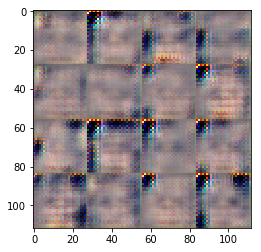

Epoch 1/1 steps 410... Discriminator Loss: 0.8301... Generator Loss: 1.2729
Epoch 1/1 steps 420... Discriminator Loss: 1.3936... Generator Loss: 0.5088
Epoch 1/1 steps 430... Discriminator Loss: 1.0466... Generator Loss: 3.6994
Epoch 1/1 steps 440... Discriminator Loss: 0.9093... Generator Loss: 1.0294
Epoch 1/1 steps 450... Discriminator Loss: 0.5760... Generator Loss: 1.5642
Epoch 1/1 steps 460... Discriminator Loss: 1.0449... Generator Loss: 0.9005
Epoch 1/1 steps 470... Discriminator Loss: 0.5025... Generator Loss: 1.8839
Epoch 1/1 steps 480... Discriminator Loss: 1.3310... Generator Loss: 1.4798
Epoch 1/1 steps 490... Discriminator Loss: 1.5889... Generator Loss: 0.5099
Epoch 1/1 steps 500... Discriminator Loss: 1.2735... Generator Loss: 0.6792


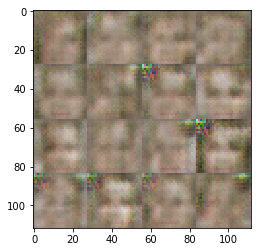

Epoch 1/1 steps 510... Discriminator Loss: 1.5685... Generator Loss: 0.4534
Epoch 1/1 steps 520... Discriminator Loss: 1.4337... Generator Loss: 0.7336
Epoch 1/1 steps 530... Discriminator Loss: 1.5674... Generator Loss: 1.0647
Epoch 1/1 steps 540... Discriminator Loss: 1.6745... Generator Loss: 1.5958
Epoch 1/1 steps 550... Discriminator Loss: 1.3294... Generator Loss: 1.8087
Epoch 1/1 steps 560... Discriminator Loss: 1.0789... Generator Loss: 0.8288
Epoch 1/1 steps 570... Discriminator Loss: 0.9132... Generator Loss: 1.0037
Epoch 1/1 steps 580... Discriminator Loss: 1.2163... Generator Loss: 0.6785
Epoch 1/1 steps 590... Discriminator Loss: 1.6803... Generator Loss: 1.1568
Epoch 1/1 steps 600... Discriminator Loss: 1.6106... Generator Loss: 0.8235


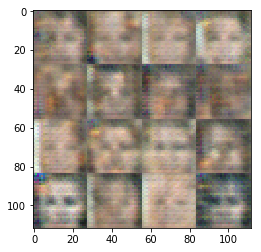

Epoch 1/1 steps 610... Discriminator Loss: 1.4077... Generator Loss: 0.4840
Epoch 1/1 steps 620... Discriminator Loss: 1.7069... Generator Loss: 0.4894
Epoch 1/1 steps 630... Discriminator Loss: 1.2186... Generator Loss: 0.9350
Epoch 1/1 steps 640... Discriminator Loss: 1.0142... Generator Loss: 0.8293
Epoch 1/1 steps 650... Discriminator Loss: 2.1361... Generator Loss: 0.8415
Epoch 1/1 steps 660... Discriminator Loss: 1.4262... Generator Loss: 0.4211
Epoch 1/1 steps 670... Discriminator Loss: 1.4071... Generator Loss: 0.6283
Epoch 1/1 steps 680... Discriminator Loss: 1.2511... Generator Loss: 0.5727
Epoch 1/1 steps 690... Discriminator Loss: 1.3037... Generator Loss: 0.6491
Epoch 1/1 steps 700... Discriminator Loss: 1.3342... Generator Loss: 0.5485


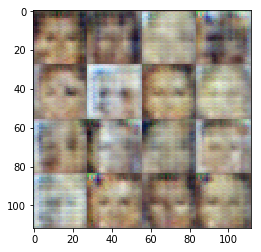

Epoch 1/1 steps 710... Discriminator Loss: 1.2989... Generator Loss: 0.6481
Epoch 1/1 steps 720... Discriminator Loss: 1.3377... Generator Loss: 1.0106
Epoch 1/1 steps 730... Discriminator Loss: 1.6416... Generator Loss: 0.5082
Epoch 1/1 steps 740... Discriminator Loss: 0.9322... Generator Loss: 1.0319
Epoch 1/1 steps 750... Discriminator Loss: 1.1045... Generator Loss: 1.3737
Epoch 1/1 steps 760... Discriminator Loss: 1.2870... Generator Loss: 0.9365
Epoch 1/1 steps 770... Discriminator Loss: 1.4109... Generator Loss: 0.9869
Epoch 1/1 steps 780... Discriminator Loss: 1.8201... Generator Loss: 0.4058
Epoch 1/1 steps 790... Discriminator Loss: 1.4512... Generator Loss: 0.5641
Epoch 1/1 steps 800... Discriminator Loss: 1.4907... Generator Loss: 0.7636


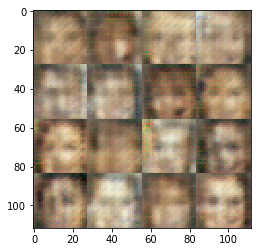

Epoch 1/1 steps 810... Discriminator Loss: 1.0685... Generator Loss: 0.9014
Epoch 1/1 steps 820... Discriminator Loss: 1.1883... Generator Loss: 0.9053
Epoch 1/1 steps 830... Discriminator Loss: 1.4475... Generator Loss: 0.4899
Epoch 1/1 steps 840... Discriminator Loss: 1.3489... Generator Loss: 0.8210
Epoch 1/1 steps 850... Discriminator Loss: 1.2885... Generator Loss: 1.1515
Epoch 1/1 steps 860... Discriminator Loss: 1.2236... Generator Loss: 0.6951
Epoch 1/1 steps 870... Discriminator Loss: 1.3635... Generator Loss: 0.5921
Epoch 1/1 steps 880... Discriminator Loss: 1.2837... Generator Loss: 0.7403
Epoch 1/1 steps 890... Discriminator Loss: 1.4619... Generator Loss: 0.6599
Epoch 1/1 steps 900... Discriminator Loss: 1.2839... Generator Loss: 0.7524


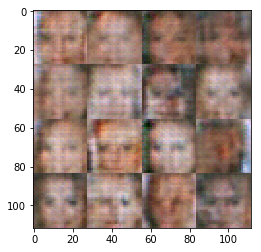

Epoch 1/1 steps 910... Discriminator Loss: 1.5115... Generator Loss: 0.7551
Epoch 1/1 steps 920... Discriminator Loss: 1.3449... Generator Loss: 0.7798
Epoch 1/1 steps 930... Discriminator Loss: 1.1849... Generator Loss: 0.9013
Epoch 1/1 steps 940... Discriminator Loss: 1.2314... Generator Loss: 0.9130
Epoch 1/1 steps 950... Discriminator Loss: 1.2674... Generator Loss: 0.6785
Epoch 1/1 steps 960... Discriminator Loss: 1.1584... Generator Loss: 0.7504
Epoch 1/1 steps 970... Discriminator Loss: 1.4480... Generator Loss: 0.5667
Epoch 1/1 steps 980... Discriminator Loss: 1.4620... Generator Loss: 0.9084
Epoch 1/1 steps 990... Discriminator Loss: 1.2186... Generator Loss: 0.8294
Epoch 1/1 steps 1000... Discriminator Loss: 1.2737... Generator Loss: 0.8396


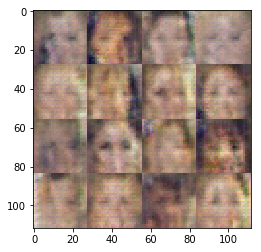

Epoch 1/1 steps 1010... Discriminator Loss: 1.3770... Generator Loss: 0.6963
Epoch 1/1 steps 1020... Discriminator Loss: 1.3655... Generator Loss: 0.6698
Epoch 1/1 steps 1030... Discriminator Loss: 1.1810... Generator Loss: 0.7518
Epoch 1/1 steps 1040... Discriminator Loss: 1.3073... Generator Loss: 0.8780
Epoch 1/1 steps 1050... Discriminator Loss: 1.4012... Generator Loss: 0.7204
Epoch 1/1 steps 1060... Discriminator Loss: 1.4844... Generator Loss: 0.4860
Epoch 1/1 steps 1070... Discriminator Loss: 1.4157... Generator Loss: 0.7570
Epoch 1/1 steps 1080... Discriminator Loss: 1.6859... Generator Loss: 0.4953
Epoch 1/1 steps 1090... Discriminator Loss: 1.4366... Generator Loss: 0.4390
Epoch 1/1 steps 1100... Discriminator Loss: 1.4138... Generator Loss: 0.7242


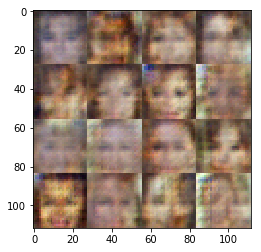

Epoch 1/1 steps 1110... Discriminator Loss: 1.0785... Generator Loss: 1.0283
Epoch 1/1 steps 1120... Discriminator Loss: 1.1736... Generator Loss: 0.8186
Epoch 1/1 steps 1130... Discriminator Loss: 1.5882... Generator Loss: 0.8224
Epoch 1/1 steps 1140... Discriminator Loss: 1.1454... Generator Loss: 0.7282
Epoch 1/1 steps 1150... Discriminator Loss: 1.1225... Generator Loss: 0.9082
Epoch 1/1 steps 1160... Discriminator Loss: 1.5134... Generator Loss: 0.5841
Epoch 1/1 steps 1170... Discriminator Loss: 1.3109... Generator Loss: 0.6921
Epoch 1/1 steps 1180... Discriminator Loss: 0.9811... Generator Loss: 0.7844
Epoch 1/1 steps 1190... Discriminator Loss: 1.3900... Generator Loss: 0.6955
Epoch 1/1 steps 1200... Discriminator Loss: 1.5488... Generator Loss: 0.6878


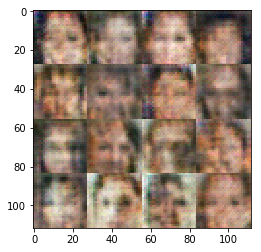

Epoch 1/1 steps 1210... Discriminator Loss: 1.3541... Generator Loss: 0.6342
Epoch 1/1 steps 1220... Discriminator Loss: 1.6238... Generator Loss: 0.6127
Epoch 1/1 steps 1230... Discriminator Loss: 1.3204... Generator Loss: 0.5791
Epoch 1/1 steps 1240... Discriminator Loss: 1.5722... Generator Loss: 0.8506
Epoch 1/1 steps 1250... Discriminator Loss: 1.3784... Generator Loss: 0.9441
Epoch 1/1 steps 1260... Discriminator Loss: 1.2684... Generator Loss: 0.9379
Epoch 1/1 steps 1270... Discriminator Loss: 1.4916... Generator Loss: 0.7415
Epoch 1/1 steps 1280... Discriminator Loss: 1.4395... Generator Loss: 0.8065
Epoch 1/1 steps 1290... Discriminator Loss: 1.4009... Generator Loss: 0.5643
Epoch 1/1 steps 1300... Discriminator Loss: 1.3566... Generator Loss: 0.8612


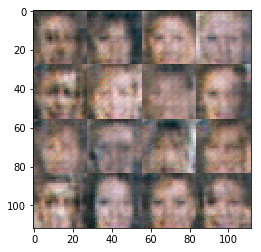

Epoch 1/1 steps 1310... Discriminator Loss: 1.5654... Generator Loss: 0.6298
Epoch 1/1 steps 1320... Discriminator Loss: 1.1510... Generator Loss: 0.8513
Epoch 1/1 steps 1330... Discriminator Loss: 1.4060... Generator Loss: 0.6211
Epoch 1/1 steps 1340... Discriminator Loss: 1.4482... Generator Loss: 0.5353
Epoch 1/1 steps 1350... Discriminator Loss: 1.2916... Generator Loss: 0.6847
Epoch 1/1 steps 1360... Discriminator Loss: 1.0241... Generator Loss: 0.8795
Epoch 1/1 steps 1370... Discriminator Loss: 1.5672... Generator Loss: 0.8235
Epoch 1/1 steps 1380... Discriminator Loss: 1.1751... Generator Loss: 0.8047
Epoch 1/1 steps 1390... Discriminator Loss: 1.4845... Generator Loss: 0.5757
Epoch 1/1 steps 1400... Discriminator Loss: 1.4560... Generator Loss: 0.8225


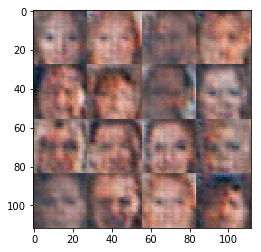

Epoch 1/1 steps 1410... Discriminator Loss: 1.1554... Generator Loss: 0.7434
Epoch 1/1 steps 1420... Discriminator Loss: 1.3056... Generator Loss: 0.9435
Epoch 1/1 steps 1430... Discriminator Loss: 1.2704... Generator Loss: 0.8258
Epoch 1/1 steps 1440... Discriminator Loss: 1.3992... Generator Loss: 0.7560
Epoch 1/1 steps 1450... Discriminator Loss: 1.4252... Generator Loss: 0.5754
Epoch 1/1 steps 1460... Discriminator Loss: 1.1985... Generator Loss: 0.7533
Epoch 1/1 steps 1470... Discriminator Loss: 1.3195... Generator Loss: 0.7268
Epoch 1/1 steps 1480... Discriminator Loss: 1.3641... Generator Loss: 0.5507
Epoch 1/1 steps 1490... Discriminator Loss: 1.3516... Generator Loss: 0.7004
Epoch 1/1 steps 1500... Discriminator Loss: 1.4117... Generator Loss: 0.5860


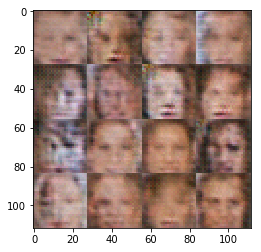

Epoch 1/1 steps 1510... Discriminator Loss: 1.1177... Generator Loss: 0.7962
Epoch 1/1 steps 1520... Discriminator Loss: 1.6328... Generator Loss: 0.4446
Epoch 1/1 steps 1530... Discriminator Loss: 1.2325... Generator Loss: 0.7200
Epoch 1/1 steps 1540... Discriminator Loss: 1.1953... Generator Loss: 0.8207
Epoch 1/1 steps 1550... Discriminator Loss: 1.3627... Generator Loss: 0.6925
Epoch 1/1 steps 1560... Discriminator Loss: 1.6248... Generator Loss: 0.5734
Epoch 1/1 steps 1570... Discriminator Loss: 1.3477... Generator Loss: 0.7957
Epoch 1/1 steps 1580... Discriminator Loss: 1.6133... Generator Loss: 0.5412
Epoch 1/1 steps 1590... Discriminator Loss: 1.3446... Generator Loss: 0.7509
Epoch 1/1 steps 1600... Discriminator Loss: 1.4302... Generator Loss: 0.7552


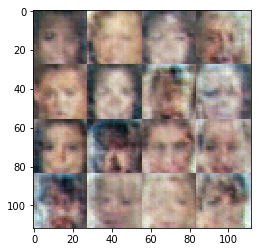

Epoch 1/1 steps 1610... Discriminator Loss: 1.3148... Generator Loss: 0.7513
Epoch 1/1 steps 1620... Discriminator Loss: 1.2928... Generator Loss: 0.7478
Epoch 1/1 steps 1630... Discriminator Loss: 1.4834... Generator Loss: 0.7900
Epoch 1/1 steps 1640... Discriminator Loss: 1.1679... Generator Loss: 0.6869
Epoch 1/1 steps 1650... Discriminator Loss: 1.2541... Generator Loss: 0.6564
Epoch 1/1 steps 1660... Discriminator Loss: 1.3266... Generator Loss: 0.6317
Epoch 1/1 steps 1670... Discriminator Loss: 1.0770... Generator Loss: 1.2216
Epoch 1/1 steps 1680... Discriminator Loss: 1.4366... Generator Loss: 0.6307
Epoch 1/1 steps 1690... Discriminator Loss: 1.2489... Generator Loss: 0.9802
Epoch 1/1 steps 1700... Discriminator Loss: 1.3499... Generator Loss: 0.5067


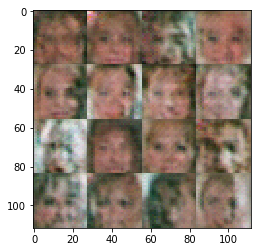

Epoch 1/1 steps 1710... Discriminator Loss: 1.4512... Generator Loss: 1.1362
Epoch 1/1 steps 1720... Discriminator Loss: 1.1527... Generator Loss: 0.8428
Epoch 1/1 steps 1730... Discriminator Loss: 1.4011... Generator Loss: 0.7238
Epoch 1/1 steps 1740... Discriminator Loss: 1.4664... Generator Loss: 0.9934
Epoch 1/1 steps 1750... Discriminator Loss: 1.0495... Generator Loss: 0.9126
Epoch 1/1 steps 1760... Discriminator Loss: 1.2416... Generator Loss: 0.6724
Epoch 1/1 steps 1770... Discriminator Loss: 1.1325... Generator Loss: 0.6298
Epoch 1/1 steps 1780... Discriminator Loss: 1.3183... Generator Loss: 0.6863
Epoch 1/1 steps 1790... Discriminator Loss: 1.1105... Generator Loss: 0.7345
Epoch 1/1 steps 1800... Discriminator Loss: 1.3100... Generator Loss: 0.6631


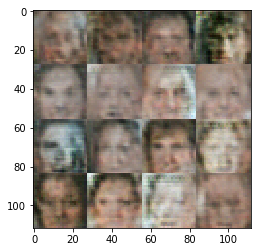

Epoch 1/1 steps 1810... Discriminator Loss: 1.0013... Generator Loss: 0.9578
Epoch 1/1 steps 1820... Discriminator Loss: 1.0779... Generator Loss: 1.3687
Epoch 1/1 steps 1830... Discriminator Loss: 0.8122... Generator Loss: 1.4024
Epoch 1/1 steps 1840... Discriminator Loss: 1.2060... Generator Loss: 0.6568
Epoch 1/1 steps 1850... Discriminator Loss: 1.1809... Generator Loss: 0.9009
Epoch 1/1 steps 1860... Discriminator Loss: 1.2643... Generator Loss: 1.0992
Epoch 1/1 steps 1870... Discriminator Loss: 1.4848... Generator Loss: 0.5115
Epoch 1/1 steps 1880... Discriminator Loss: 1.4374... Generator Loss: 0.9109
Epoch 1/1 steps 1890... Discriminator Loss: 1.1582... Generator Loss: 0.6370
Epoch 1/1 steps 1900... Discriminator Loss: 1.8639... Generator Loss: 0.7988


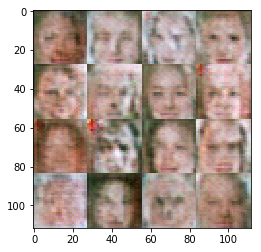

Epoch 1/1 steps 1910... Discriminator Loss: 1.2602... Generator Loss: 0.5081
Epoch 1/1 steps 1920... Discriminator Loss: 1.5149... Generator Loss: 0.8063
Epoch 1/1 steps 1930... Discriminator Loss: 1.1316... Generator Loss: 1.8054
Epoch 1/1 steps 1940... Discriminator Loss: 1.2877... Generator Loss: 0.8049
Epoch 1/1 steps 1950... Discriminator Loss: 1.3365... Generator Loss: 0.7906
Epoch 1/1 steps 1960... Discriminator Loss: 1.2744... Generator Loss: 0.8844
Epoch 1/1 steps 1970... Discriminator Loss: 1.2027... Generator Loss: 0.6765
Epoch 1/1 steps 1980... Discriminator Loss: 1.3017... Generator Loss: 0.6316
Epoch 1/1 steps 1990... Discriminator Loss: 1.2660... Generator Loss: 0.7729
Epoch 1/1 steps 2000... Discriminator Loss: 0.8326... Generator Loss: 1.0401


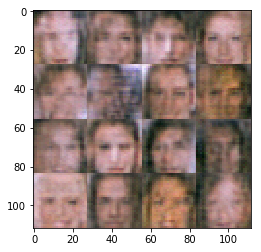

Epoch 1/1 steps 2010... Discriminator Loss: 1.1427... Generator Loss: 0.5987
Epoch 1/1 steps 2020... Discriminator Loss: 0.5906... Generator Loss: 2.4092
Epoch 1/1 steps 2030... Discriminator Loss: 1.7509... Generator Loss: 0.3057
Epoch 1/1 steps 2040... Discriminator Loss: 1.3984... Generator Loss: 0.7003
Epoch 1/1 steps 2050... Discriminator Loss: 1.2456... Generator Loss: 0.8063
Epoch 1/1 steps 2060... Discriminator Loss: 1.2497... Generator Loss: 0.7906
Epoch 1/1 steps 2070... Discriminator Loss: 1.0298... Generator Loss: 1.1789
Epoch 1/1 steps 2080... Discriminator Loss: 1.0824... Generator Loss: 0.8367
Epoch 1/1 steps 2090... Discriminator Loss: 1.2507... Generator Loss: 1.2532
Epoch 1/1 steps 2100... Discriminator Loss: 1.1188... Generator Loss: 0.7209


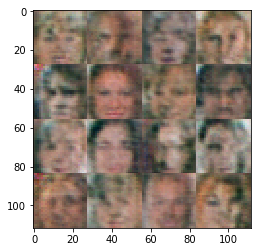

Epoch 1/1 steps 2110... Discriminator Loss: 1.4131... Generator Loss: 0.5886
Epoch 1/1 steps 2120... Discriminator Loss: 1.4578... Generator Loss: 0.4798
Epoch 1/1 steps 2130... Discriminator Loss: 1.2561... Generator Loss: 0.7639
Epoch 1/1 steps 2140... Discriminator Loss: 1.6337... Generator Loss: 0.7023
Epoch 1/1 steps 2150... Discriminator Loss: 1.3245... Generator Loss: 0.6911
Epoch 1/1 steps 2160... Discriminator Loss: 1.3609... Generator Loss: 0.6992
Epoch 1/1 steps 2170... Discriminator Loss: 1.3280... Generator Loss: 0.8196
Epoch 1/1 steps 2180... Discriminator Loss: 1.2455... Generator Loss: 0.6736
Epoch 1/1 steps 2190... Discriminator Loss: 1.2100... Generator Loss: 0.7307
Epoch 1/1 steps 2200... Discriminator Loss: 1.4004... Generator Loss: 0.5787


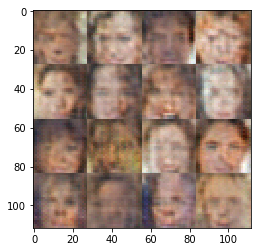

Epoch 1/1 steps 2210... Discriminator Loss: 1.3231... Generator Loss: 1.0275
Epoch 1/1 steps 2220... Discriminator Loss: 1.1455... Generator Loss: 0.7711
Epoch 1/1 steps 2230... Discriminator Loss: 1.2076... Generator Loss: 0.6952
Epoch 1/1 steps 2240... Discriminator Loss: 1.2302... Generator Loss: 0.9938
Epoch 1/1 steps 2250... Discriminator Loss: 1.2728... Generator Loss: 0.6125
Epoch 1/1 steps 2260... Discriminator Loss: 1.3356... Generator Loss: 0.6926
Epoch 1/1 steps 2270... Discriminator Loss: 1.4243... Generator Loss: 0.7227
Epoch 1/1 steps 2280... Discriminator Loss: 1.3040... Generator Loss: 0.6465
Epoch 1/1 steps 2290... Discriminator Loss: 1.5541... Generator Loss: 0.7103
Epoch 1/1 steps 2300... Discriminator Loss: 1.4999... Generator Loss: 0.5292


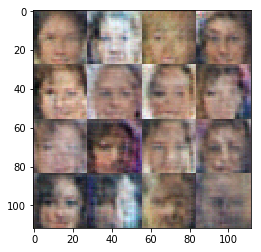

Epoch 1/1 steps 2310... Discriminator Loss: 1.1964... Generator Loss: 0.7204
Epoch 1/1 steps 2320... Discriminator Loss: 1.3758... Generator Loss: 0.6984
Epoch 1/1 steps 2330... Discriminator Loss: 1.3446... Generator Loss: 0.7492
Epoch 1/1 steps 2340... Discriminator Loss: 1.4037... Generator Loss: 0.6802
Epoch 1/1 steps 2350... Discriminator Loss: 1.3339... Generator Loss: 0.7866
Epoch 1/1 steps 2360... Discriminator Loss: 1.2785... Generator Loss: 0.6767
Epoch 1/1 steps 2370... Discriminator Loss: 1.3108... Generator Loss: 0.5341
Epoch 1/1 steps 2380... Discriminator Loss: 1.4982... Generator Loss: 0.6737
Epoch 1/1 steps 2390... Discriminator Loss: 1.4602... Generator Loss: 0.7212
Epoch 1/1 steps 2400... Discriminator Loss: 1.2512... Generator Loss: 0.8282


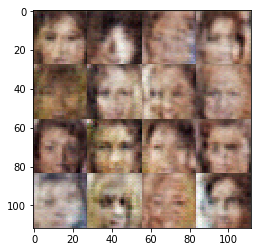

Epoch 1/1 steps 2410... Discriminator Loss: 1.3805... Generator Loss: 0.6458
Epoch 1/1 steps 2420... Discriminator Loss: 1.3270... Generator Loss: 0.8355
Epoch 1/1 steps 2430... Discriminator Loss: 1.4343... Generator Loss: 0.6282
Epoch 1/1 steps 2440... Discriminator Loss: 1.4206... Generator Loss: 0.7060
Epoch 1/1 steps 2450... Discriminator Loss: 1.2102... Generator Loss: 0.7706
Epoch 1/1 steps 2460... Discriminator Loss: 1.3783... Generator Loss: 0.6279
Epoch 1/1 steps 2470... Discriminator Loss: 1.1943... Generator Loss: 0.7230
Epoch 1/1 steps 2480... Discriminator Loss: 1.3133... Generator Loss: 0.6864
Epoch 1/1 steps 2490... Discriminator Loss: 1.3961... Generator Loss: 0.8949
Epoch 1/1 steps 2500... Discriminator Loss: 1.4479... Generator Loss: 0.7757


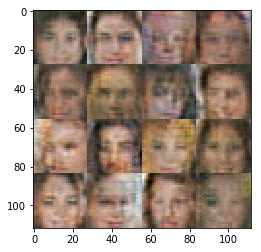

Epoch 1/1 steps 2510... Discriminator Loss: 1.3951... Generator Loss: 0.7955
Epoch 1/1 steps 2520... Discriminator Loss: 1.3129... Generator Loss: 0.7042
Epoch 1/1 steps 2530... Discriminator Loss: 1.3290... Generator Loss: 0.6560
Epoch 1/1 steps 2540... Discriminator Loss: 1.2917... Generator Loss: 0.7567
Epoch 1/1 steps 2550... Discriminator Loss: 1.2843... Generator Loss: 0.7084
Epoch 1/1 steps 2560... Discriminator Loss: 1.4964... Generator Loss: 0.6252
Epoch 1/1 steps 2570... Discriminator Loss: 1.2831... Generator Loss: 0.7262
Epoch 1/1 steps 2580... Discriminator Loss: 1.3135... Generator Loss: 0.6877
Epoch 1/1 steps 2590... Discriminator Loss: 1.4354... Generator Loss: 0.6492
Epoch 1/1 steps 2600... Discriminator Loss: 1.2954... Generator Loss: 0.6779


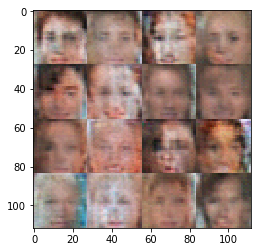

Epoch 1/1 steps 2610... Discriminator Loss: 1.3478... Generator Loss: 0.6638
Epoch 1/1 steps 2620... Discriminator Loss: 1.2804... Generator Loss: 0.7473
Epoch 1/1 steps 2630... Discriminator Loss: 1.2306... Generator Loss: 0.8058
Epoch 1/1 steps 2640... Discriminator Loss: 1.3967... Generator Loss: 0.7275
Epoch 1/1 steps 2650... Discriminator Loss: 1.3233... Generator Loss: 0.7101
Epoch 1/1 steps 2660... Discriminator Loss: 1.4976... Generator Loss: 0.7337
Epoch 1/1 steps 2670... Discriminator Loss: 1.2728... Generator Loss: 0.7448
Epoch 1/1 steps 2680... Discriminator Loss: 1.2996... Generator Loss: 0.7513
Epoch 1/1 steps 2690... Discriminator Loss: 1.4569... Generator Loss: 0.6488
Epoch 1/1 steps 2700... Discriminator Loss: 1.2182... Generator Loss: 0.7187


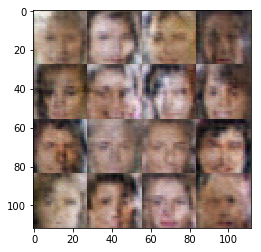

Epoch 1/1 steps 2710... Discriminator Loss: 1.4125... Generator Loss: 0.6285
Epoch 1/1 steps 2720... Discriminator Loss: 1.3781... Generator Loss: 0.7375
Epoch 1/1 steps 2730... Discriminator Loss: 1.3236... Generator Loss: 0.7430
Epoch 1/1 steps 2740... Discriminator Loss: 1.2461... Generator Loss: 0.8006
Epoch 1/1 steps 2750... Discriminator Loss: 1.3487... Generator Loss: 0.8000
Epoch 1/1 steps 2760... Discriminator Loss: 1.5008... Generator Loss: 0.6567
Epoch 1/1 steps 2770... Discriminator Loss: 1.3183... Generator Loss: 0.6931
Epoch 1/1 steps 2780... Discriminator Loss: 1.4667... Generator Loss: 0.6391
Epoch 1/1 steps 2790... Discriminator Loss: 1.3255... Generator Loss: 0.7093
Epoch 1/1 steps 2800... Discriminator Loss: 1.3407... Generator Loss: 0.6991


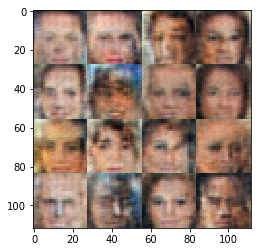

Epoch 1/1 steps 2810... Discriminator Loss: 1.3813... Generator Loss: 0.7285
Epoch 1/1 steps 2820... Discriminator Loss: 1.3276... Generator Loss: 0.7194
Epoch 1/1 steps 2830... Discriminator Loss: 1.2598... Generator Loss: 0.7332
Epoch 1/1 steps 2840... Discriminator Loss: 1.4060... Generator Loss: 0.7013
Epoch 1/1 steps 2850... Discriminator Loss: 1.4017... Generator Loss: 0.5916
Epoch 1/1 steps 2860... Discriminator Loss: 1.2865... Generator Loss: 0.7803
Epoch 1/1 steps 2870... Discriminator Loss: 1.2953... Generator Loss: 0.7494
Epoch 1/1 steps 2880... Discriminator Loss: 1.3868... Generator Loss: 0.7285
Epoch 1/1 steps 2890... Discriminator Loss: 1.4170... Generator Loss: 0.6649
Epoch 1/1 steps 2900... Discriminator Loss: 1.3230... Generator Loss: 0.7036


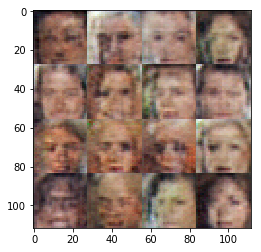

Epoch 1/1 steps 2910... Discriminator Loss: 1.2687... Generator Loss: 0.7717
Epoch 1/1 steps 2920... Discriminator Loss: 1.4124... Generator Loss: 0.7431
Epoch 1/1 steps 2930... Discriminator Loss: 1.3015... Generator Loss: 0.7706
Epoch 1/1 steps 2940... Discriminator Loss: 1.4772... Generator Loss: 0.7003
Epoch 1/1 steps 2950... Discriminator Loss: 1.2797... Generator Loss: 0.7619
Epoch 1/1 steps 2960... Discriminator Loss: 1.4274... Generator Loss: 0.6472
Epoch 1/1 steps 2970... Discriminator Loss: 1.2958... Generator Loss: 0.7124
Epoch 1/1 steps 2980... Discriminator Loss: 1.3440... Generator Loss: 0.6212
Epoch 1/1 steps 2990... Discriminator Loss: 1.3852... Generator Loss: 0.6589
Epoch 1/1 steps 3000... Discriminator Loss: 1.3611... Generator Loss: 0.6999


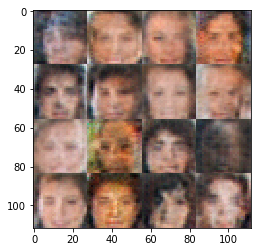

Epoch 1/1 steps 3010... Discriminator Loss: 1.2420... Generator Loss: 0.7730
Epoch 1/1 steps 3020... Discriminator Loss: 1.3930... Generator Loss: 0.8136
Epoch 1/1 steps 3030... Discriminator Loss: 1.2632... Generator Loss: 0.7706
Epoch 1/1 steps 3040... Discriminator Loss: 1.3191... Generator Loss: 0.7551
Epoch 1/1 steps 3050... Discriminator Loss: 1.1780... Generator Loss: 0.8370
Epoch 1/1 steps 3060... Discriminator Loss: 1.3607... Generator Loss: 0.7054
Epoch 1/1 steps 3070... Discriminator Loss: 1.2165... Generator Loss: 0.8005
Epoch 1/1 steps 3080... Discriminator Loss: 1.2413... Generator Loss: 0.7947
Epoch 1/1 steps 3090... Discriminator Loss: 1.3658... Generator Loss: 0.8362
Epoch 1/1 steps 3100... Discriminator Loss: 1.4471... Generator Loss: 0.6906


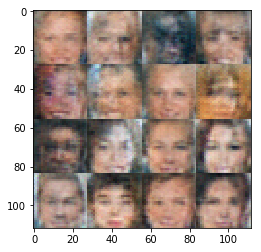

Epoch 1/1 steps 3110... Discriminator Loss: 1.2643... Generator Loss: 0.8648
Epoch 1/1 steps 3120... Discriminator Loss: 1.2471... Generator Loss: 0.8557
Epoch 1/1 steps 3130... Discriminator Loss: 1.3333... Generator Loss: 0.5961
Epoch 1/1 steps 3140... Discriminator Loss: 1.3710... Generator Loss: 0.6562
Epoch 1/1 steps 3150... Discriminator Loss: 1.3886... Generator Loss: 0.7421
Epoch 1/1 steps 3160... Discriminator Loss: 1.3472... Generator Loss: 0.7382
end of loop
about to exit train()
done training celeba
done-tf.graph
done celeba_dataset (202599, 28, 28, 3)RGB


In [77]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    print("done training celeba")
print("done-tf.graph")

print("done celeba_dataset {}{}".format(celeba_dataset.shape, celeba_dataset.image_mode))


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.